In [1]:
import numpy as np
import sys
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.model_selection import train_test_split
import torch
from skorch import NeuralNetRegressor
from copy import deepcopy
import matplotlib.pyplot as plt

sys.path.insert(1, '../')
from data import load_narx_data
from model import Narx

In [2]:
n_epochs=int(5e1)
na_list=[*range(3,8)]
nb_list=[*range(14,26)]
final_losses=np.ndarray((len(na_list),len(nb_list)))
final_best_RMSs=np.ndarray((len(na_list),len(nb_list)))

In [3]:
for i, na in enumerate(na_list):
    for j, nb in enumerate(nb_list):
        x,y = load_narx_data(na, nb)
        x_train, x_val, y_train, y_val =train_test_split(x, y, shuffle=False)
        n_hidden_nodes= na+nb
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        x_train, x_val, y_train, y_val=[x.to(device) for x in [x_train, x_val, y_train, y_val]]
        best_RMS=float('inf')
        best_model=None
        losses=[]
        RMSs=[]
        best_RMSs=[]

        model = Narx(x_train.shape[1], n_hidden_nodes).to(device) #a=)
        optimizer = torch.optim.Adam(model.parameters()) #a)
        for epoch in range(n_epochs): #a)
            Loss = torch.mean((model(x_train)-y_train)**2) #a)
            optimizer.zero_grad() #a)
            Loss.backward() #a)
            optimizer.step() #a)
            if (epoch+1)%min((n_epochs//20),1000)==0: #a) monitor
                print(f"current run: {na, nb}, epoch: {epoch+1}, Loss: {Loss.item()}") #a)
                RMS=np.mean((y_val.detach().cpu().numpy()-model.forward(x_val).detach().cpu().numpy())**2)**0.5
                if RMS < best_RMS:
                    best_RMS=RMS
                    best_model=deepcopy(model)
                    print(f"current RMS: {RMS}, best RMS: {best_RMS}")
                losses.append(Loss.item())
                RMSs.append(RMS)
                best_RMSs.append(best_RMS)
        final_losses[i,j]=losses[-1]
        final_best_RMSs[i,j]=best_RMSs[-1]


current run: (3, 14), epoch: 2, Loss: 0.4837332425875587
current RMS: 0.6808618103779476, best RMS: 0.6808618103779476
current run: (3, 14), epoch: 4, Loss: 0.46031417083889825
current RMS: 0.6640200394389789, best RMS: 0.6640200394389789
current run: (3, 14), epoch: 6, Loss: 0.4379235545082351
current RMS: 0.6475376210934953, best RMS: 0.6475376210934953
current run: (3, 14), epoch: 8, Loss: 0.416585744546467
current RMS: 0.6314593804202316, best RMS: 0.6314593804202316
current run: (3, 14), epoch: 10, Loss: 0.39631874252083993
current RMS: 0.6158287974135878, best RMS: 0.6158287974135878
current run: (3, 14), epoch: 12, Loss: 0.37713380092503446
current RMS: 0.600687230240471, best RMS: 0.600687230240471
current run: (3, 14), epoch: 14, Loss: 0.3590351369782156
current RMS: 0.5860731190265059, best RMS: 0.5860731190265059
current run: (3, 14), epoch: 16, Loss: 0.34201979206098426
current RMS: 0.5720212066129219, best RMS: 0.5720212066129219
current run: (3, 14), epoch: 18, Loss: 0.32

C:\Users\Leo\AppData\Local\Temp\ipykernel_12128\1888364149.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([0]+na_list)
C:\Users\Leo\AppData\Local\Temp\ipykernel_12128\1888364149.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([0]+na_list)


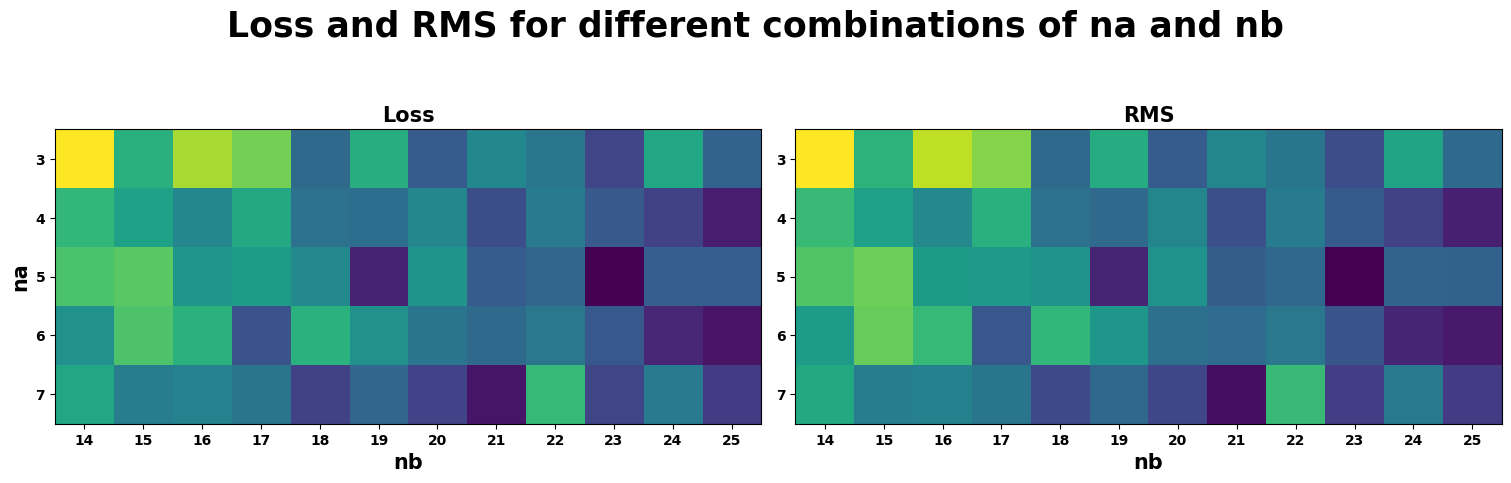

In [25]:
fs=15
fig = plt.figure(figsize=(15, 5),layout='constrained')
ax1=fig.add_subplot(121)
ax1.imshow(final_losses, interpolation='none', norm='log')
ax2=fig.add_subplot(122)
ax2.imshow(final_best_RMSs, interpolation='none', norm='log')
ax1.set_title('Loss',fontsize=fs)
ax2.set_title('RMS',fontsize=fs)
fig.suptitle('Loss and RMS for different combinations of na and nb for NARX', fontsize=25)
ax1.set_ylabel('na',fontsize=fs)
ax1.set_xlabel('nb',fontsize=fs)
ax2.set_xlabel('nb',fontsize=fs)
ax1.set_yticklabels([0]+na_list)
ax1.set_xticks([*range(len(nb_list))],nb_list)
ax2.set_yticklabels([0]+na_list)
ax2.set_xticks([*range(len(nb_list))],nb_list)

In [5]:
min_arg = np.unravel_index(final_best_RMSs.argmin(keepdims=True), final_best_RMSs.shape)
params = np.zeros((len(na_list), len(nb_list), 2))
for i, na in enumerate(na_list):
    for j, nb in enumerate(nb_list):
        params[i, j, :] = [na, nb]

best_na, best_nb = params[min_arg].ravel()
f"Best na= {best_na}, best nb= {best_nb}"

'Best na= 5.0, best nb= 23.0'

In [27]:
n_hidden_list=[10,20,50,100]

best_RMS=float('inf')
best_model=None
losses=[]
RMSs=[]
best_RMSs=[]
na=5
nb=1
final_losses=[]
final_best_RMSs=[]
for n_hidden_nodes in n_hidden_list:
    x,y = load_narx_data(na, nb)
    x_train, x_val, y_train, y_val =train_test_split(x, y, shuffle=False)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    x_train, x_val, y_train, y_val=[x.to(device) for x in [x_train, x_val, y_train, y_val]]
    best_RMS=float('inf')
    best_model=None
    losses=[]
    RMSs=[]
    best_RMSs=[]

    model = Narx(x_train.shape[1], n_hidden_nodes).to(device) #a=)
    optimizer = torch.optim.Adam(model.parameters()) #a)
    for epoch in range(n_epochs): #a)
        Loss = torch.mean((model(x_train)-y_train)**2) #a)
        optimizer.zero_grad() #a)
        Loss.backward() #a)
        optimizer.step() #a)
        if (epoch+1)%min((n_epochs//20),1000)==0: #a) monitor
            print(f"current run: {n_hidden_nodes}, epoch: {epoch+1}, Loss: {Loss.item()}") #a)
            RMS=np.mean((y_val.detach().cpu().numpy()-model.forward(x_val).detach().cpu().numpy())**2)**0.5
            if RMS < best_RMS:
                best_RMS=RMS
                best_model=deepcopy(model)
                print(f"current RMS: {RMS}, best RMS: {best_RMS}")
            losses.append(Loss.item())
            RMSs.append(RMS)
            best_RMSs.append(best_RMS)
    final_losses.append(losses[-1])
    final_best_RMSs.append(best_RMSs[-1])

current run: 10, epoch: 2, Loss: 0.24165140321723894
current RMS: 0.5025144542714477, best RMS: 0.5025144542714477
current run: 10, epoch: 4, Loss: 0.23403606179390396
current RMS: 0.4948659855087321, best RMS: 0.4948659855087321
current run: 10, epoch: 6, Loss: 0.22684853999299256
current RMS: 0.48754596360070424, best RMS: 0.48754596360070424
current run: 10, epoch: 8, Loss: 0.22009815202829622
current RMS: 0.4805776506361994, best RMS: 0.4805776506361994
current run: 10, epoch: 10, Loss: 0.21379074607971968
current RMS: 0.47398105850735595, best RMS: 0.47398105850735595
current run: 10, epoch: 12, Loss: 0.20792832878146797
current RMS: 0.46777218374132795, best RMS: 0.46777218374132795
current run: 10, epoch: 14, Loss: 0.2025087624773525
current RMS: 0.4619623060668021, best RMS: 0.4619623060668021
current run: 10, epoch: 16, Loss: 0.19752555586345721
current RMS: 0.4565573968939976, best RMS: 0.4565573968939976
current run: 10, epoch: 18, Loss: 0.19296776793953402
current RMS: 0.45

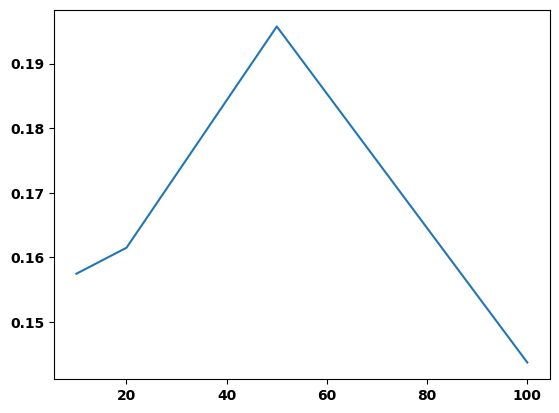

In [28]:
plt.plot(n_hidden_list,final_losses)